[View in Colaboratory](https://colab.research.google.com/github/ankanbhunia/Colab/blob/master/crd.ipynb)

In [0]:
import re
import shutil
import tensorflow as tf
from __future__ import division
import matplotlib.pyplot as plt

MP_NAME = 'mp'

params = {'batch_size' : 1,
          'train_log' : 'train_log99',
          'model_dir' : 'model1558',
          'output_dir' : 'output',
          'log_device_placement' : False,
          'data_train_gt' : '/content/Data_original/Data_gt/train_gt/',
          'data_train_im' : '/content/Data_original/Data_im/train_im/',
          'data_train_index' : '/content/Data_original/dir_name.txt',
          'num_epochs_per_decay' : 20,
          'learning_rate_per_decay' : 0.9,
          'initial_learning_rate' :1.0e-1  
}

In [0]:


def get_loss(predict, label):

    l2_loss = tf.reduce_sum((predict - label) * (predict - label))

    tf.summary.histogram('loss', l2_loss)

    return l2_loss


def add_avg_loss(avg_loss):

    add_avg_loss_op = avg_loss * 1
    tf.summary.histogram('avg_loss', avg_loss)

    return add_avg_loss_op


def _add_loss_summaries(total_loss):

    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    for l in losses + [total_loss]:
        tf.summary.scalar(l.op.name + ' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))

    return loss_averages_op


def train(total_loss, global_step, nums_per_train):

    num_batches_per_epoch = nums_per_train / params['batch_size']
    decay_steps = int(num_batches_per_epoch * params['num_epochs_per_decay'])

    lr = tf.train.exponential_decay(params['initial_learning_rate'],
                                    global_step,
                                    decay_steps,
                                    params['learning_rate_per_decay'],
                                    staircase=True)
    tf.summary.scalar('learning_rate', lr)

  
    opt = tf.train.RMSPropOptimizer(lr)
    grads = opt.compute_gradients(total_loss)


    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
    train_op = apply_gradient_op

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    return train_op

In [0]:
class batch_norm(object):
            # h1 = lrelu(tf.contrib.layers.batch_norm(conv2d(h0, self.df_dim*2, name='d_h1_conv'),decay=0.9,updates_collections=None,epsilon=0.00001,scale=True,scope="d_h1_conv"))
    def __init__(self, epsilon=0.001, momentum = 0, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x, decay=self.momentum, updates_collections=None, epsilon=self.epsilon, scale=True, scope=self.name)

def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=1, d_w=1, stddev=0.02,
           name="conv2d",relu = True, bn = True):
    
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)
        if relu:
            conv  = tf.nn.relu(conv)
        if bn:
            bnF = batch_norm(name = name+'_bn')
            conv = bnF(conv)
        
        return conv

In [0]:
def inference_bn_(Input):
    
    with tf.variable_scope('Network', reuse=tf.AUTO_REUSE):

        with tf.variable_scope('Branch1') as scope:

            Branch1_conv1 = conv2d(Input, 16, 9, 9, name = 'conv1')
            Branch1_pool1 = tf.layers.max_pooling2d(Branch1_conv1, 2, 2, padding = 'same')
            Branch1_conv2 = conv2d(Branch1_pool1, 32, 7, 7, name = 'conv2')
            Branch1_pool2 = tf.layers.max_pooling2d(Branch1_conv2, 2, 2, padding = 'same')
            Branch1_conv3 = conv2d(Branch1_pool2, 16, 7, 7, name = 'conv3')
            Branch1_conv4 = conv2d(Branch1_conv3, 8, 7, 7, name = 'conv4')

        with tf.variable_scope('Branch2') as scope:

            Branch2_conv1 = conv2d(Input, 20, 7, 7, name = 'conv1')
            Branch2_pool1 = tf.layers.max_pooling2d(Branch2_conv1, 2, 2, padding = 'same')
            Branch2_conv2 = conv2d(Branch2_pool1, 40, 5, 5, name = 'conv2')
            Branch2_pool2 = tf.layers.max_pooling2d(Branch2_conv2, 2, 2, padding = 'same')
            Branch2_conv3 = conv2d(Branch2_pool2, 20, 5, 5, name = 'conv3')
            Branch2_conv4 = conv2d(Branch2_conv3, 10, 5, 5, name = 'conv4')

        with tf.variable_scope('Branch3') as scope:

            Branch3_conv1 = conv2d(Input, 24, 5, 5, name = 'conv1')
            Branch3_pool1 = tf.layers.max_pooling2d(Branch3_conv1, 2, 2, padding = 'same')
            Branch3_conv2 = conv2d(Branch3_pool1, 48, 3, 3, name = 'conv2')
            Branch3_pool2 = tf.layers.max_pooling2d(Branch3_conv2, 2, 2, padding = 'same')
            Branch3_conv3 = conv2d(Branch3_pool2, 24, 3, 3, name = 'conv3')
            Branch3_conv4 = conv2d(Branch3_conv3, 12, 3, 3, name = 'conv4')

        with tf.variable_scope('fuse') as scope:

            Fuse = tf.concat([Branch1_conv4, Branch2_conv4, Branch3_conv4],-1)
            Out = conv2d(Fuse, 1, 1, 1, name = 'Out')

        return tf.nn.relu(tf.nn.sigmoid(Out))

In [0]:
def get_ranking_loss(predicts, gt):
    
    counts = [tf.squeeze(i,[0]) for i in tf.split(predicts,params['batch_size'],0)]
    counts_gt = [tf.squeeze(i,[0]) for i in tf.split(gt,params['batch_size'],0)]
 
    
    def _ranking_loss_(i_c,j_c,i_gt,j_gt):
        return tf.cond(i_gt<j_gt, lambda: tf.maximum(0.0, i_c - j_c), lambda: tf.maximum(0.0, j_c - i_c))

    import itertools
    ranking_loss = 0
    
    for i,j in itertools.combinations(np.arange(params['batch_size']), 2):
        ranking_loss = ranking_loss + _ranking_loss_(tf.reduce_sum(counts[i]), tf.reduce_sum(counts[j]), tf.reduce_sum(counts_gt[i]), tf.reduce_sum(counts_gt[j]))
    
    return ranking_loss

In [0]:
def get_data(dir_name):
  
  nums_train = len(dir_name)
  
  num_batch = np.random.choice(nums_train,params['batch_size'])#random.sample(range(nums_train), nums_train)[0:params['batch_size']]
  
  hw = []

  xs, ys = [], []

  for index in num_batch:

      file_name = dir_name[index]
      im_name, gt_name = file_name.split(' ')
      gt_name = gt_name.split('\n')[0]


      batch_xs = cv2.imread(params['data_train_im'] + im_name)
      batch_xs = (np.array(batch_xs, dtype=np.float32))


      batch_ys = np.array(np.load(params['data_train_gt'] + gt_name))
      batch_ys = np.array(batch_ys, dtype=np.float32)
      batch_ys = batch_ys.reshape([batch_ys.shape[0], batch_ys.shape[1], -1])

      w,h,_ = batch_xs.shape

      hw.append([w,h])


      xs.append(batch_xs)
      ys.append(batch_ys)
      
  hw = np.array(hw)
  w0,h0 = np.min(hw[:,0]), np.min(hw[:,1])

  
  xs_, ys_ = [], []
  for batch_xs,batch_ys in zip(xs,ys):
    
    if np.random.choice(2)==1:
        batch_xs = cv2.flip(batch_xs,1)
        batch_ys = cv2.flip(batch_ys,1)
        if len(batch_ys.shape)==2:
          batch_ys = np.expand_dims(batch_ys,-1)

    w,h,_ = batch_xs.shape

    randw = np.random.random()
    randh = np.random.random()

    W0 = int(randw*(w-w0))
    H0 = int(randh*(h-h0))


    batch_xs = batch_xs[W0:W0+w0,H0:H0+h0,:]

    batch_ys = batch_ys[W0//4:W0//4+np.ceil(w0/4).astype('int'),H0//4:H0//4+np.ceil(h0/4).astype('int'),:]

    xs_.append(batch_xs)
    ys_.append(batch_ys)
    

  np_xs = np.stack(xs_,0)
  np_ys = np.stack(ys_,0)


  
  return np_xs, np_ys


##36200 >> avg_loss:1.0786515	  GT:69.9999542	 predict:135.3260193


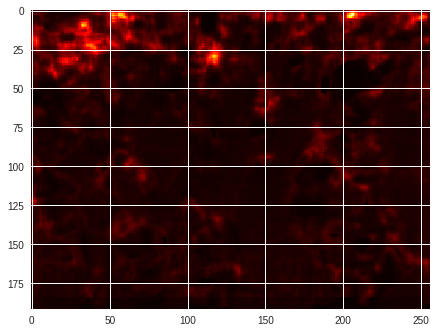

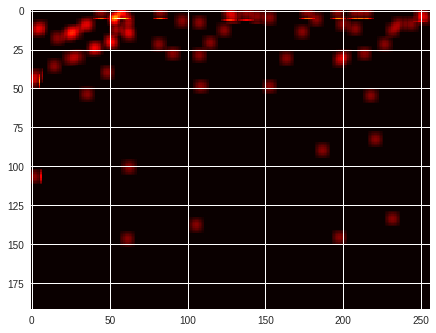

##36300 >> avg_loss:0.5205252	  GT:26.9999924	 predict:88.5307312


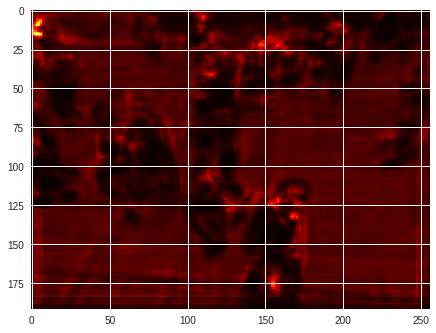

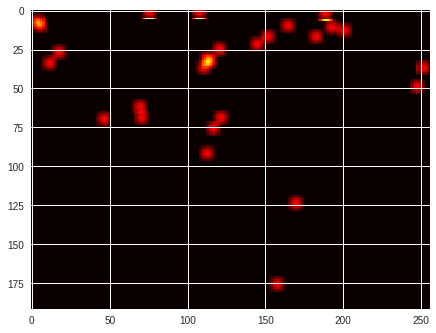

##36400 >> avg_loss:3.1278491	  GT:106.0000610	 predict:246.4944611


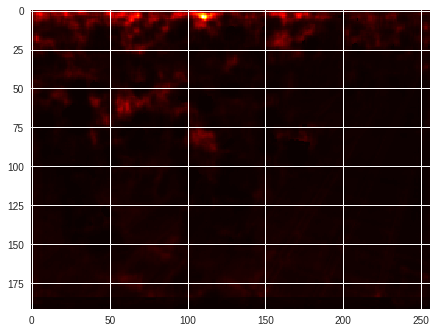

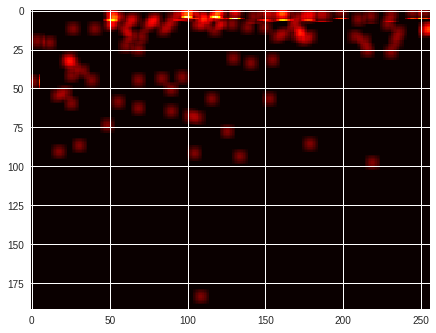

##36500 >> avg_loss:9.0418119	  GT:291.0001526	 predict:343.4664307


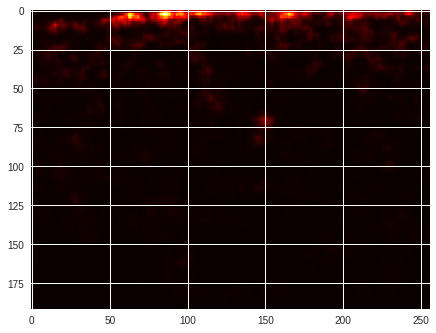

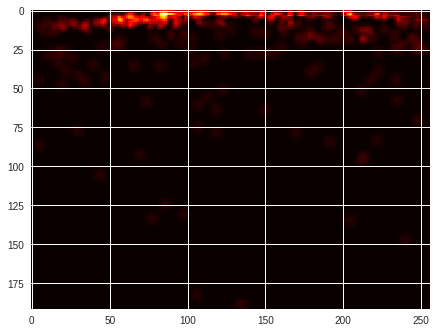

##36600 >> avg_loss:2.7060492	  GT:81.0000000	 predict:163.6054077


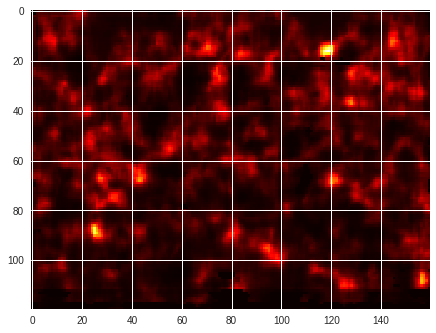

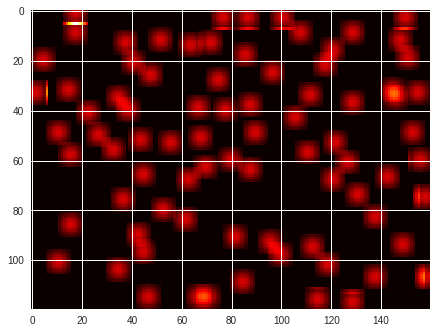

##36700 >> avg_loss:10.8238487	  GT:252.0000305	 predict:313.2134705


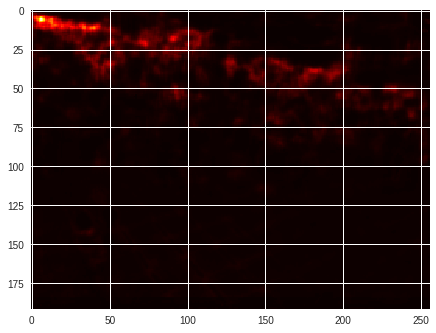

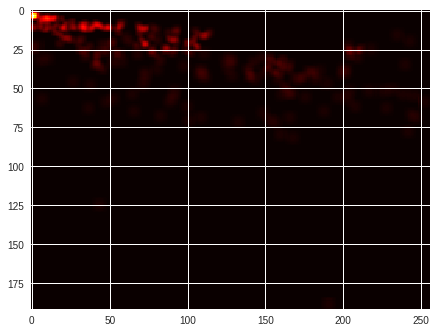

##36800 >> avg_loss:3.8772674	  GT:114.0000076	 predict:180.0806274


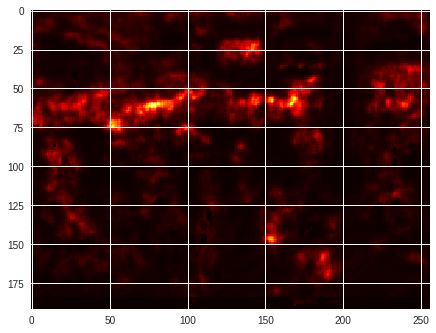

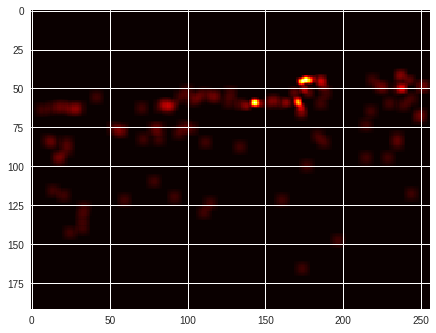

##36900 >> avg_loss:205.5181885	  GT:1545.9995117	 predict:2268.5922852


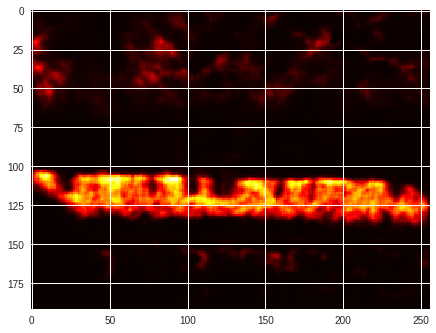

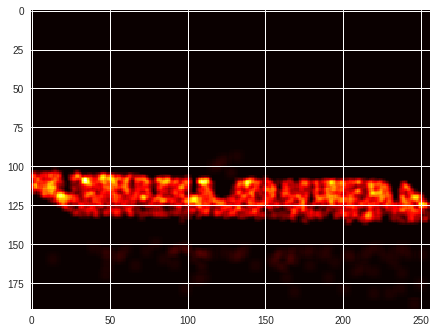

##37000 >> avg_loss:49.8593292	  GT:1044.9998779	 predict:893.6777344


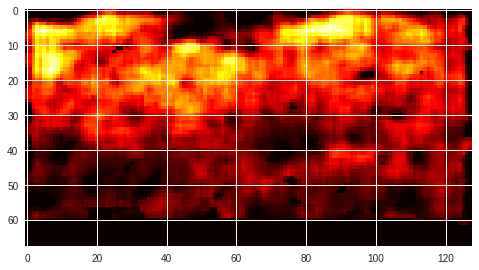

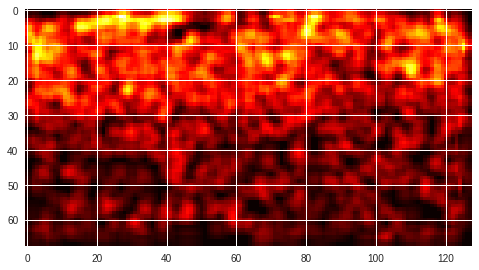

##37100 >> avg_loss:17.0932236	  GT:291.0000610	 predict:157.7316589


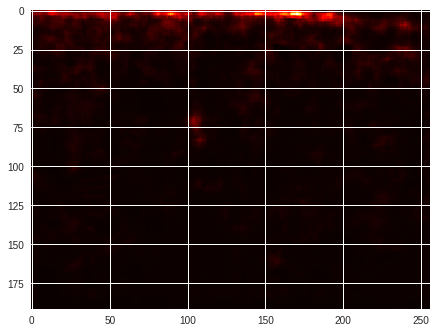

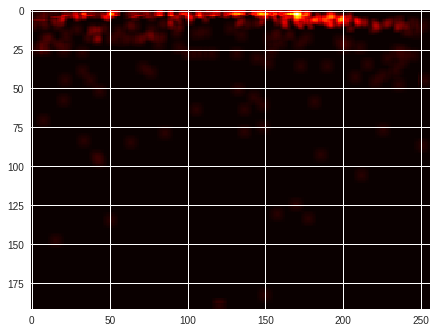

##37200 >> avg_loss:17.3738270	  GT:275.9998779	 predict:222.8323822


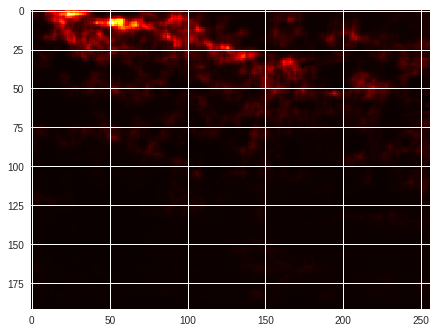

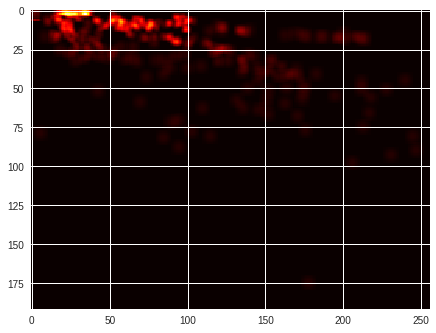

##37300 >> avg_loss:2.6702788	  GT:116.9999771	 predict:191.8118591


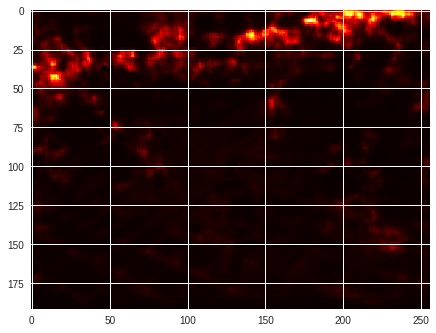

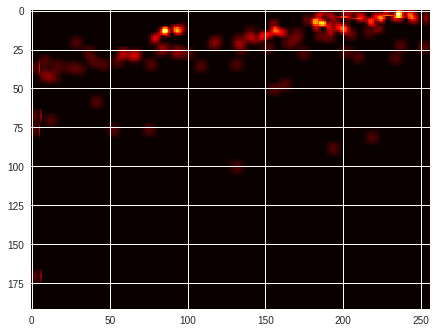

##37400 >> avg_loss:8.0076580	  GT:372.9999695	 predict:336.8608704


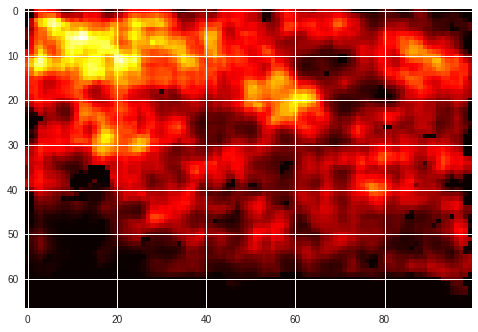

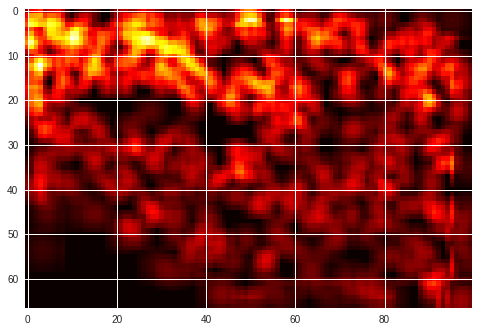

##37500 >> avg_loss:2.5595305	  GT:96.0000000	 predict:149.0035706


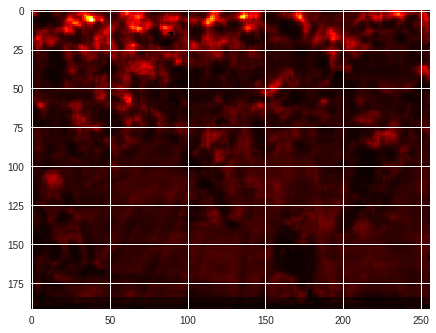

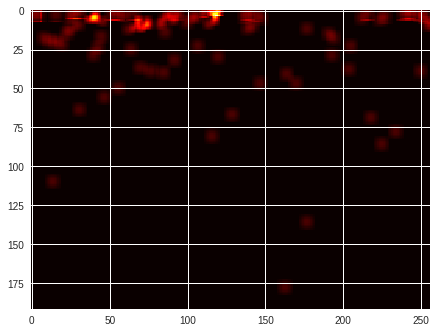

##37600 >> avg_loss:1.1797590	  GT:59.9999695	 predict:170.3092957


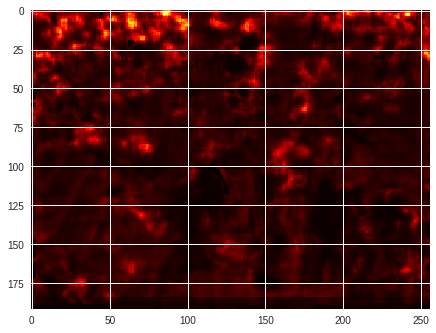

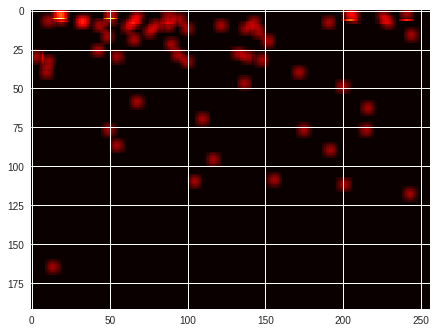

##37700 >> avg_loss:5.5243158	  GT:258.9999695	 predict:254.9535675


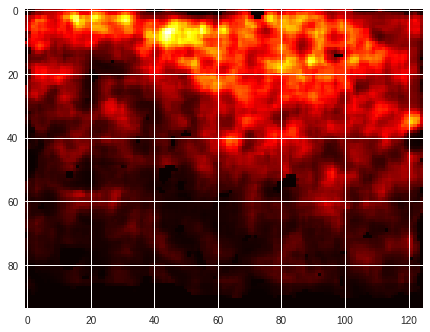

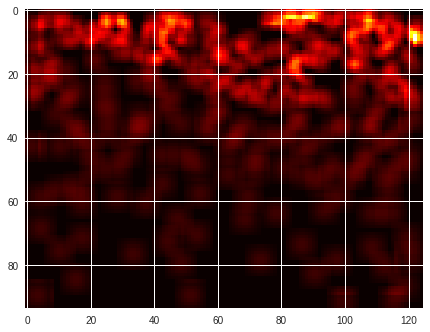

##37800 >> avg_loss:6.3492475	  GT:387.9998779	 predict:443.6916199


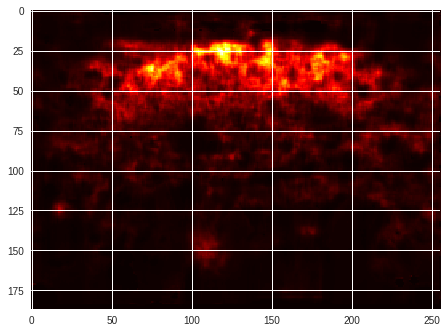

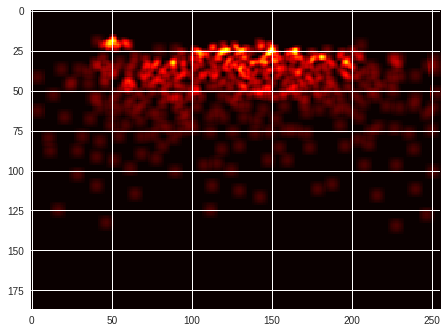

##37900 >> avg_loss:16.3138847	  GT:340.9999084	 predict:284.2650146


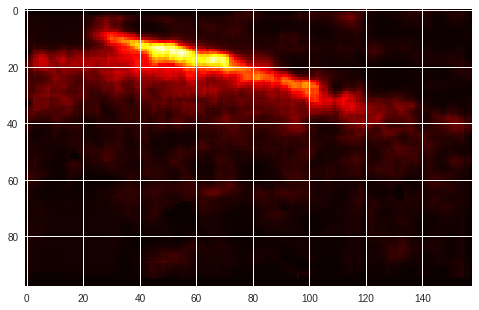

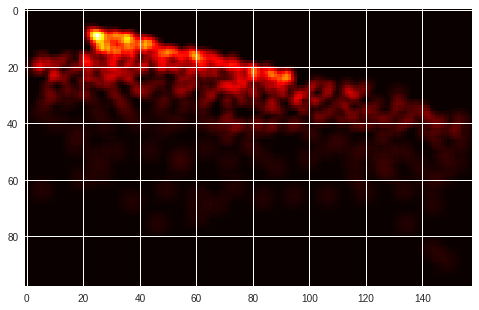

##38000 >> avg_loss:21.2362976	  GT:413.9999390	 predict:602.0327148


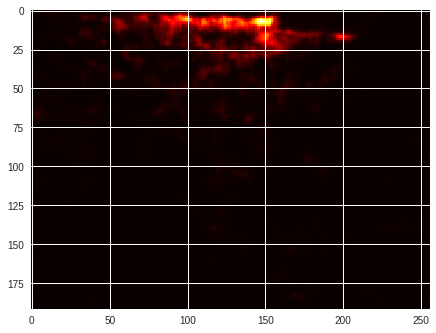

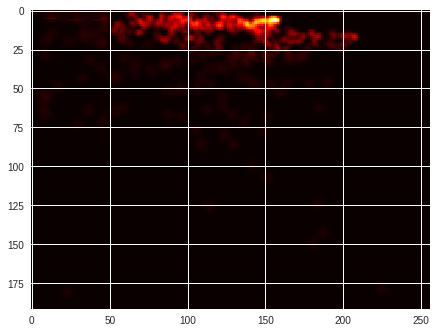

##38100 >> avg_loss:2.5198479	  GT:159.0000305	 predict:186.2858734


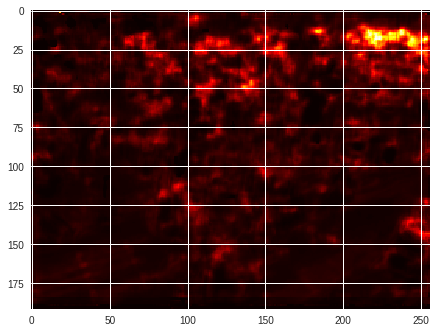

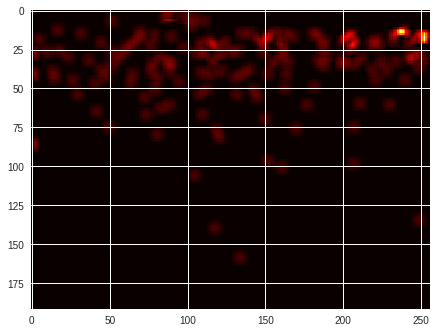

##38200 >> avg_loss:1.0451026	  GT:42.9999847	 predict:158.1842804


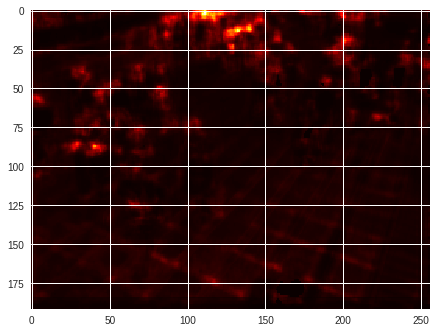

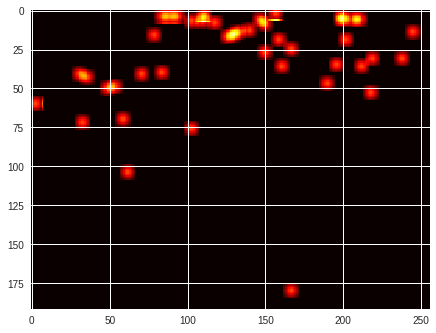

##38300 >> avg_loss:37.7805748	  GT:760.0001221	 predict:965.4443359


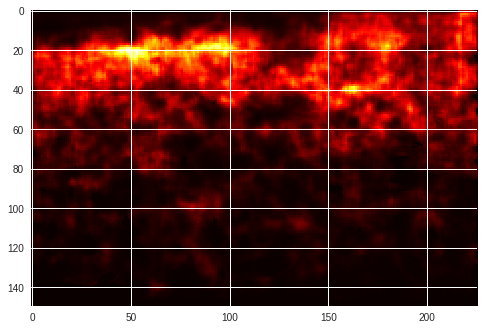

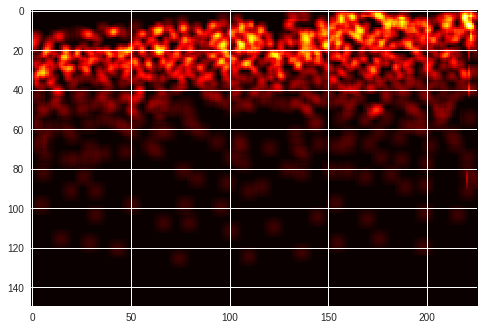

##38400 >> avg_loss:12.7135258	  GT:219.0000610	 predict:268.1054688


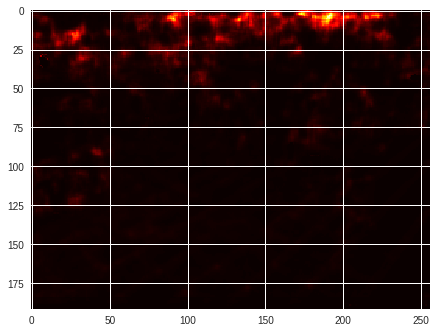

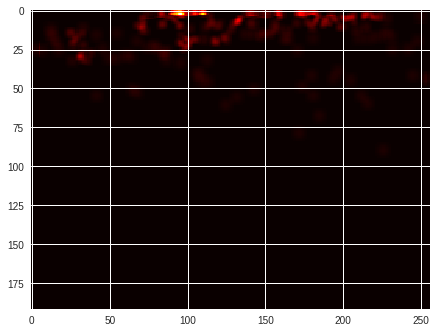

##38500 >> avg_loss:3.8277783	  GT:178.0000458	 predict:188.0095062


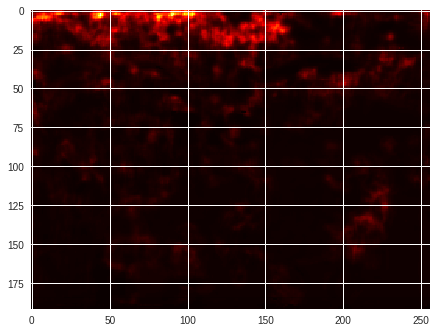

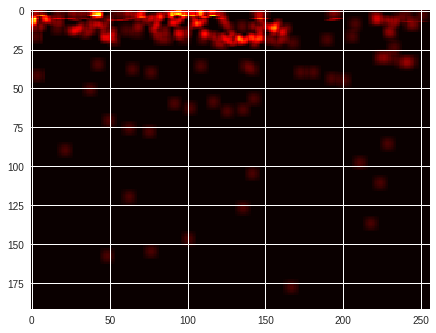

##38600 >> avg_loss:1.4336314	  GT:90.0000458	 predict:167.9286957


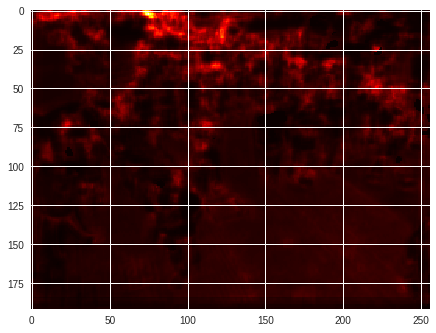

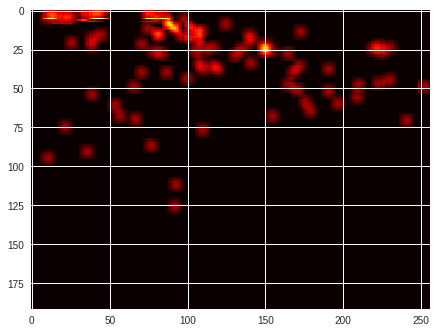

##38700 >> avg_loss:8.8101034	  GT:722.9999390	 predict:476.2580261


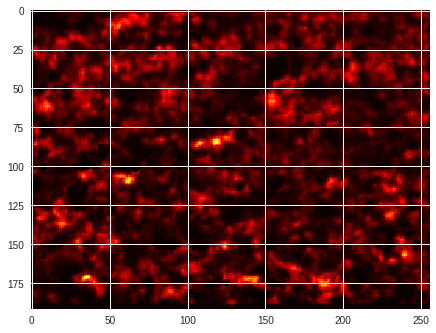

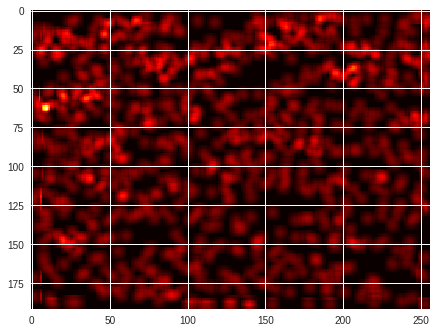

##38800 >> avg_loss:0.8131291	  GT:35.9999695	 predict:118.6566620


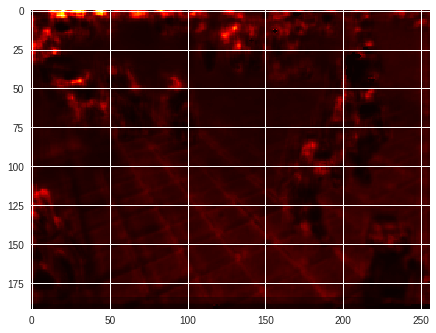

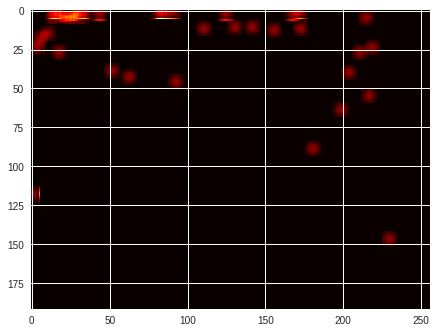

##38900 >> avg_loss:6.1518569	  GT:200.9999390	 predict:279.6588135


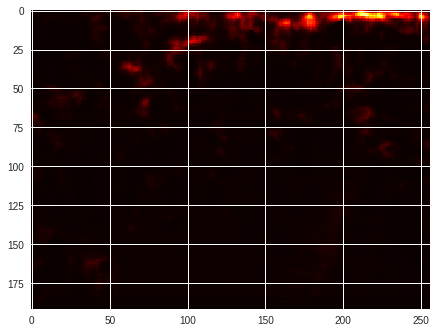

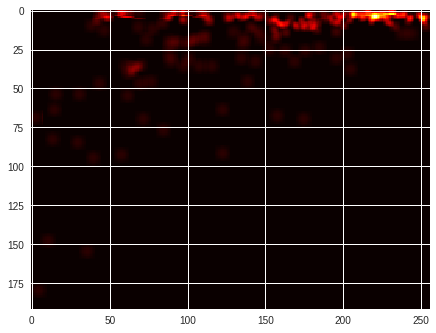

##39000 >> avg_loss:15.5372057	  GT:408.0000916	 predict:538.1121216


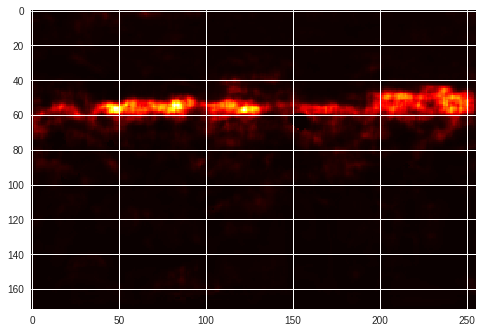

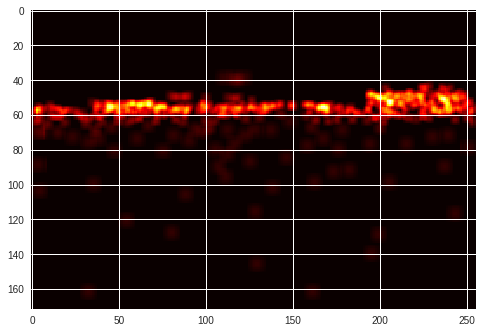

##39100 >> avg_loss:6.4589906	  GT:205.0000916	 predict:206.0426483


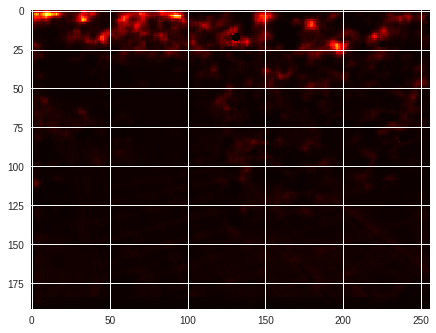

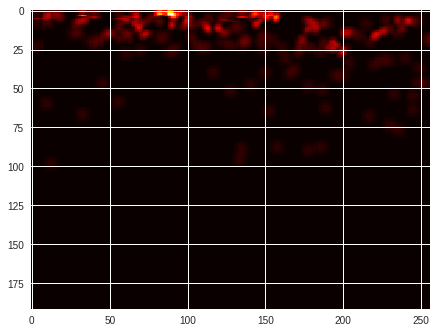

##39200 >> avg_loss:1.0620830	  GT:55.9999962	 predict:139.3959198


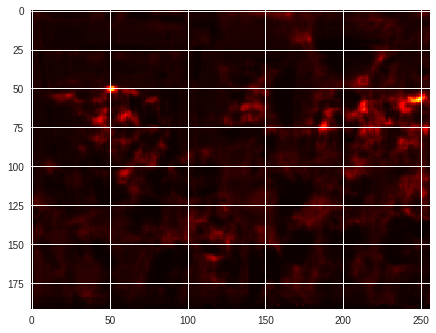

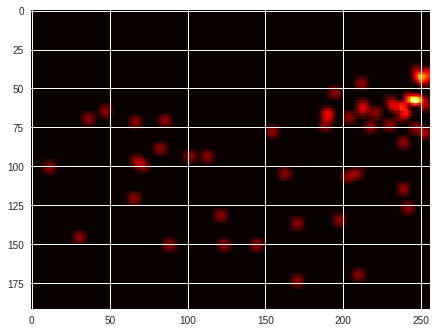

##39300 >> avg_loss:2.2597547	  GT:257.0000610	 predict:251.2506256


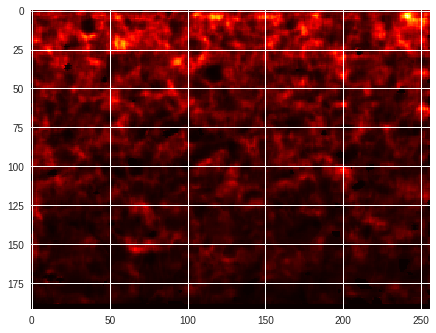

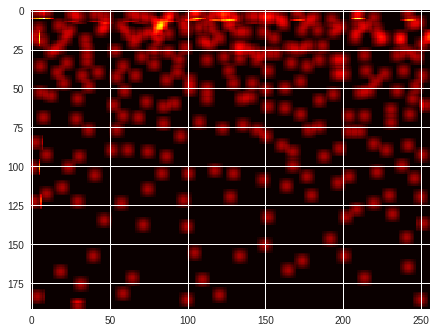

In [0]:

import os.path
import random
import cv2
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np


num_epochs_per_decay = 20
learning_rate_per_decay = 0.9
initial_learning_rate = 1.0e-1


def Compile():
    fig = plt.figure()
    with tf.Graph().as_default():
        
        dir_file = open(params['data_train_index'])
        dir_name = dir_file.readlines()

    
        nums_train = len(dir_name)
        global_step = tf.Variable(0, trainable=False)

   
        image = tf.placeholder("float",[params['batch_size'],None,None,3])
        label = tf.placeholder("float",[params['batch_size'],None,None,1])
        avg_loss = tf.placeholder("float")

        predicts = inference_bn_(image) 
        rnking_loss = get_ranking_loss(predicts, label)
        loss = get_loss(predicts, label)  + rnking_loss
        train_op = train(loss, global_step, nums_train)  

        sess = tf.Session()  
        saver = tf.train.Saver(tf.all_variables())  

        init = tf.initialize_all_variables()  
        sess.run(init)  

        checkpoint_dir = tf.train.get_checkpoint_state(params['model_dir'])
        if checkpoint_dir and checkpoint_dir.model_checkpoint_path:
            saver.restore(sess, checkpoint_dir.model_checkpoint_path)
        else:
            print('Not found checkpoint file')

        summary_op = tf.summary.merge_all() 
        add_avg_loss_op = add_avg_loss(avg_loss)  
        summary_writer = tf.summary.FileWriter(params['train_log'], graph_def=sess.graph_def)

        steps = 100000
        avg_loss_1 = 0

        for step in xrange(steps):
            #if step < nums_train * 10:
               
              #  num_batch = [divmod(step, nums_train)[1] + i for i in range(params['batch_size'])]
                
            #else:
               
            np_xs, np_ys = get_data(dir_name)
         
            _, loss_value = sess.run([train_op, loss], feed_dict={image: np_xs, label: np_ys})
            
            output = sess.run(predicts, feed_dict={image: np_xs})
            avg_loss_1 += loss_value

            if step % 100 == 0:
              
                summary_str = sess.run(summary_op, feed_dict={image: np_xs, label: np_ys,
                                                              avg_loss: avg_loss_1 / 100})
                summary_writer.add_summary(summary_str, step)
                avg_loss_1 = 0

            if step % 100 == 0:
              
                print("##"+str(step)+" >> avg_loss:%.7f\t  GT:%.7f\t predict:%.7f" % \
                      (loss_value, sum(sum(sum(np_ys[0]))), sum(sum(sum(output[0])))))
                
                sess.run(add_avg_loss_op, feed_dict={avg_loss: loss_value})
                
                plt.imshow(output[0,:,:,0],cmap = 'hot')

                plt.show()
                plt.imshow(np_ys[0,:,:,0] ,cmap = 'hot')

                plt.show()
                
                #print (output[0],np_ys[0])
                
                #plt.imshow(np.concatenate([output[0,:,:,0],np_ys[0,:,:,0] ],1),cmap = 'hot')

                #plt.show()
                
                

            if step % 2000 == 0:
                checkpoint_path = os.path.join(params['model_dir'], 'skip_mcnn.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)

            if step % 500 == 0:
                out_path = os.path.join(params['output_dir'], str(step) + "out.npy")
                np.save(out_path, output)


def main(argv=None):
    if gfile.Exists(params['train_log']):
        shutil.rmtree(params['train_log'],ignore_errors=True)
    gfile.MakeDirs(params['train_log'])

    if not gfile.Exists(params['model_dir']):
        gfile.MakeDirs(params['model_dir'])

    if not gfile.Exists(params['output_dir']):
        gfile.MakeDirs(params['output_dir'])

    Compile()


if __name__ == '__main__':
    tf.app.run()
